# Combination Encoder Decoder Tranformers to Summarize Documents with Text Clustering and Topic Modeling




---
### Import Modules

In [42]:
from bertopic import BERTopic
from bertopic.representation import TextGeneration
from copy import deepcopy
from datasets import load_dataset
from hdbscan import HDBSCAN

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from transformers import pipeline
from umap import UMAP

####  Loading the data

I use a [subset](https://huggingface.co/datasets/MaartenGr/arxiv_nlp) of the [arXiv Dataset](https://www.kaggle.com/datasets/Cornell-University/arxiv) that was created by [Maarten Grootendorst](https://www.linkedin.com/in/mgrootendorst/) specifically for the _[Hands-On Large Language Models](https://www.oreilly.com/library/view/hands-on-large-language/9781098150952/)_ book.


In [43]:
dataset = load_dataset("maartengr/arxiv_nlp")["train"]
dataset

Dataset({
    features: ['Titles', 'Abstracts', 'Years', 'Categories'],
    num_rows: 44949
})

In [3]:
# Getting abstracts and the titles
abstracts = dataset["Abstracts"]
titles = dataset["Titles"]

In [4]:
# Check out examples of abstracts 
abstracts[0:2]

['  In this paper Arabic was investigated from the speech recognition problem\npoint of view. We propose a novel approach to build an Arabic Automated Speech\nRecognition System (ASR). This system is based on the open source CMU Sphinx-4,\nfrom the Carnegie Mellon University. CMU Sphinx is a large-vocabulary;\nspeaker-independent, continuous speech recognition system based on discrete\nHidden Markov Models (HMMs). We build a model using utilities from the\nOpenSource CMU Sphinx. We will demonstrate the possible adaptability of this\nsystem to Arabic voice recognition.\n',
 '  In this paper we present the creation of an Arabic version of Automated\nSpeech Recognition System (ASR). This system is based on the open source\nSphinx-4, from the Carnegie Mellon University. Which is a speech recognition\nsystem based on discrete hidden Markov models (HMMs). We investigate the\nchanges that must be made to the model to adapt Arabic voice recognition.\n  Keywords: Speech recognition, Acoustic mo

In [5]:
# Check out examples of titles
titles[0:2]

['Introduction to Arabic Speech Recognition Using CMUSphinx System',
 'Arabic Speech Recognition System using CMU-Sphinx4']

------
------

# Perform Text Clustering - The Encoder Part

----
----

* `Step 1` - Convert the input documents to embeddings with an [Sentence- Bidirectional Encoder Representations from Transformers (SBERT)](https://www.sbert.net/) *embedding model*.
    * I used SBERT because its main purpose is to generate fixed-size sentence embeddings, meaning it transforms entire sentences into dense vector representations that capture their semantic meaning. 
    * SBERT is an Encoder-Only Transformer which is a type of Representative AI

* `Step 2` - Next, I reduce the dimensionality of the embeddings using [UMAP](https://youtu.be/eN0wFzBA4Sc) to reduce the dimensions of the model.

* `Step 3` - Finally, I cluster the semantically similar documents using a *cluster model* derived from a [HDBSCAN](https://pberba.github.io/stats/2020/01/17/hdbscan/) algorithm. 

#### Step 1 - Converting Abstracts into Embeddings

I use the open-source (read FREE) pre-traind SBERT model: [gte-small model](https://huggingface.co/thenlper/gte-small) from hugging face. This transformer model converts the abstracts into embeddings.
* General Text Embedding (gte)
* Small refers to its relative size
    * It has 33 million paramerters, while other models may have over 100 million
* The gte-small model only accepts 512 tokens and any input that is longer than that gets truncated 
*  gte-small, is a general-purpose model designed to perform well given a wide variety of tasks, like classification and ranking, and, as a result, creates more embedding values than I need for clustering.
    * Having too many embedding values, or dimensions, results in sparse data that can be difficult to cluster and is an example of [The Curse of Dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality).

In [6]:
# Download the pre-trained SBERT model
embedding_model = SentenceTransformer('thenlper/gte-small')

# Create the embeddings for the abstracts.
embeddings = embedding_model.encode(abstracts, show_progress_bar=True)

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/68.1k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1405 [00:00<?, ?it/s]

Verify that all 44,949 abstracts have 384 word embedding values associated with them by printing out the `.shape`.

In [7]:
# Check the dimensions of the resulting embeddings
embeddings.shape

(44949, 384)

#### Step 2 - Converting Abstracts into Embeddings

Here, I use Uniform Manifold Approximation and Projection (UMAP) to reduce the dimensions from 384 to 5. 

**NOTE:** The distance metric that I am using is [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity). 

If you are not already familiar with the Cosine Similarity, check out the [StatQuest](https://youtu.be/e9U0QAFbfLI).

In [8]:
# We reduce the input embeddings from 384 dimenions to 5 dimenions
umap_model = UMAP(
    n_components=5,
    min_dist=0.0,
    metric='cosine',
    random_state=42
)
reduced_embeddings_5 = umap_model.fit_transform(embeddings)

In [9]:
# Check the dimensions of the reduced embeddings
reduced_embeddings_5.shape

(44949, 5)

#### Step 3 - Cluster the Reduced Embeddings

Now that the number of dimensions (or values) of the embeddings have been reduced from 384 to just 5, I try to find clusters using the HDBSCAN to find the clusters.

In [10]:
# Find and label clusters
hdbscan_model = HDBSCAN(
    min_cluster_size=50, # Each cluster must have >= 50 documents in it
    metric='euclidean',  # Clustering is based on euclidean distance
    cluster_selection_method='eom' # eom = Excess of Mass and is the default clustering selection method
).fit(reduced_embeddings_5)
clusters = hdbscan_model.labels_

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [11]:
# Print out the number of cluseters
len(set(clusters)) # set() removes duplicates - so we only count the unique cluster labels

160

##### Sanity Check the Clustering
Now, I examine the first cluster to see if it makes sense. 

Look at the first three abstracts in the first cluster.

In [12]:
# Print first three documents in cluster 0
cluster = 0
for index in np.where(clusters==cluster)[0][:3]:
    print(abstracts[index][:300] + "... \n")

  This works aims to design a statistical machine translation from English text
to American Sign Language (ASL). The system is based on Moses tool with some
modifications and the results are synthesized through a 3D avatar for
interpretation. First, we translate the input text to gloss, a written fo... 

  Researches on signed languages still strongly dissociate lin- guistic issues
related on phonological and phonetic aspects, and gesture studies for
recognition and synthesis purposes. This paper focuses on the imbrication of
motion and meaning for the analysis, synthesis and evaluation of sign lang... 

  Modern computational linguistic software cannot produce important aspects of
sign language translation. Using some researches we deduce that the majority of
automatic sign language translation systems ignore many aspects when they
generate animation; therefore the interpretation lost the truth inf... 



##### Visualizing the Clusters also as a Sanity Check


Drawing a graph to visualize the clusters takes two steps.  I needed to reduce the original 384 embeddings to `two` dimensions from `five` for visualization of the clustering. 

In [13]:
# Reduce 384-dimensional embeddings to 2 dimensions for easier visualization
reduced_embeddings_2 = UMAP(
    n_components=2,
    min_dist=0.0,
    metric='cosine',
    random_state=42
).fit_transform(embeddings)

# Create dataframe
df = pd.DataFrame(reduced_embeddings_2, columns=["x", "y"])
df["title"] = titles
df["cluster"] = [str(c) for c in clusters]

# Select outliers and non-outliers (clusters)
clusters_df = df.loc[df.cluster != "-1", :]
outliers_df = df.loc[df.cluster == "-1", :]

In [44]:
df.head()

x         y                                              title  \
0  5.013325  0.228933  Introduction to Arabic Speech Recognition Usin...   
1  5.023213  0.207630  Arabic Speech Recognition System using CMU-Sph...   
2  3.773625 -0.195483  On the Development of Text Input Method - Less...   
3  0.027602 -0.680204  Network statistics on early English Syntax: St...   
4  4.236195  2.198917  Segmentation and Context of Literary and Music...   

  cluster  
0     145  
1     145  
2      -1  
3      -1  
4      -1

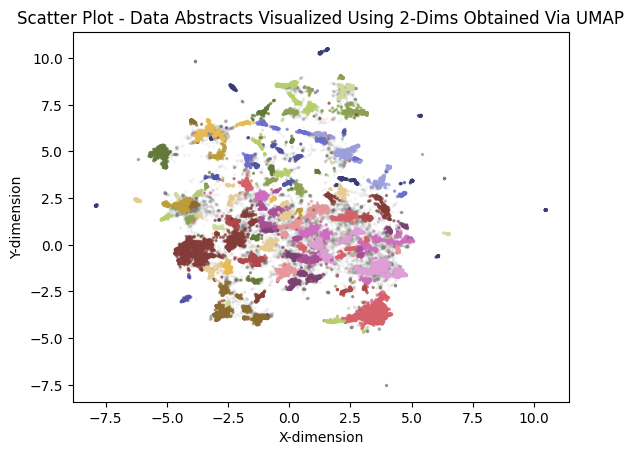

In [47]:
# Plot the 2-dimensional data
#Plot outliers and non-outliers seperately
plt.scatter(outliers_df.x, outliers_df.y, alpha=0.05, s=2, c="grey")
plt.scatter(
    clusters_df.x, clusters_df.y, c=clusters_df.cluster.astype(int),
    alpha=0.6, s=2, cmap='tab20b'
)
plt.xlabel("X-dimension")
plt.ylabel("Y-dimension")
plt.title("Scatter Plot - Data Abstracts Visualized Using 2-Dims Obtained Via UMAP")
#plt.axis('off')
plt.savefig("cluster.png", dpi=300)  # Uncomment to save the graph as a .png

The graph shows how the 44,949 abstracts got clustered. 

The figure is messy with so many clusters. Colors are reused for different clusters (this means the light green patch at the top is a distinct cluster from the light green patch close to the middle).

Now we're done with the **Text Clustering** part of this tutorial. The next step, **Topic Modeling**, gives each cluster an easy to understand label based on the overall theme that each cluster represents.

------
------

# Perform Text Topic Modeling - The Decoder Part

----
----

In this part, I performe **Topic Modeling** where I have to give each cluster an easy to understand label based on the overall theme that each cluster represents.

I perform the following to steps:

* Step 1 - Generate keywords 
* Step 2 - Feed those keywords into a generative LLM to create the labels. 

I have to use **BERTopic** to coordinate both steps.

## Step 1: Generate the Keywords

I use **BERTopic**. It is a topic modeling technique that leverages transformer models, specifically BERT embeddings and a class-based TF-IDF (c-TF-IDF), to extract meaningful topics from collections of documents. Note, a "topic" refers to a key concept or theme within a collection of texts, often derived through unsupervised learning methods. 

I use **BERTopic** to do what I did in the Text Clustering by first creating word embeddings, then reducing the dimensions of the embeddings, and then clustering. However, because I use **BERTopic** this time, it will also extract keywords representing each cluster.

The keywords are determined with a class-based variant of Term Frequency Inverse Document Frequency **c-TF-IDF**.

I have to pass **BERTopic** the embedding, UMAP, and HBDBSCAN models created earlier, and then fit it to the abstracts using the embeddings created earlier. BERTopic's process involves several steps: document embedding using transformer models like BERT to capture semantic meaning, reducing dimensionality with techniques such as UMAP to preserve data structure, clustering similar documents with algorithms like HDBSCAN, and finally extracting topic names using a class-based TF-IDF approach.


In [15]:
# Train our model with our previously defined models
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    verbose=True
).fit(abstracts, embeddings)

2025-06-17 15:45:42,866 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-17 15:46:00,301 - BERTopic - Dimensionality - Completed ✓
2025-06-17 15:46:00,302 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-17 15:46:00,813 - BERTopic - Cluster - Completed ✓
2025-06-17 15:46:00,818 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-06-17 15:46:01,987 - BERTopic - Representation - Completed ✓


Now that I have a topic model, I can print out the keywords it selected for each topic. 

**NOTE:** The first topic is labeled `-1`, which is the ID that DBSCAN gives to outliers. As a result, the very first row shows keywords for the outliers. The other rows are much more interesting.

- **Topic** is the topic ID number.
- **Count** tells us how many documents are in that cluster, so that means I had 14,882 outliers that were not part of any particular cluster.
- **Name** is the topic ID number appended to the first 4 keywords for a topic.
- **Representation** lists the keywords for a topic.
- **Representitive_Docs** lists the documents with the most occurrences of the topic's keywords.

In [16]:
topic_model.get_topic_info()

Topic  Count                                           Name  \
0       -1  14882                               -1_the_of_and_to   
1        0   2154                 0_question_qa_questions_answer   
2        1   2115                   1_speech_asr_recognition_end   
3        2    921  2_summarization_summaries_summary_abstractive   
4        3    716               3_translation_nmt_machine_neural   
..     ...    ...                                            ...   
155    154     52                154_mixed_code_sentiment_mixing   
156    155     51   155_diffusion_generation_autoregressive_text   
157    156     51          156_arabic_sentiment_analysis_dialect   
158    157     50    157_counseling_therapy_mental_psychotherapy   
159    158     50     158_coherence_discourse_paragraph_cohesion   

                                        Representation  \
0    [the, of, and, to, in, we, for, language, that...   
1    [question, qa, questions, answer, answering, a...   
2    [speech, asr, recognition, end, acoustic, spea...   
3    [summarization, summaries, summary, abstractiv...   
4    [translation, nmt, machine, neural, bleu, reso...   
..                                                 ...   
155  [mixed, code, sentiment, mixing, analysis, eng...   
156  [diffusion, generation, autoregressive, text, ...   
157  [arabic, sentiment, analysis, dialect, msa, as...   
158  [counseling, therapy, mental, psychotherapy, h...   
159  [coherence, discourse, paragraph, cohesion, te...   

                                   Representative_Docs  
0    [  Deep learning approaches are superior in NL...  
1    [  We propose a novel text generation task, na...  
2    [  We introduce Wav2Seq, the first self-superv...  
3    [  Data-driven approaches to sequence-to-seque...  
4    [  Neural Machine Translation (NMT) has obtain...  
..                                                 ...  
155  [  The usage of more than one language in the ...  
156  [  Diffusion models have achieved great succes...  
157  [  The social media network phenomenon leads t...  
158  [  Mental health care poses an increasingly se...  
159  [  While there has been significant progress t...  

[160 rows x 5 columns]

In [17]:
# To get the top 10 keywords per topic as well as their c-TF-IDF weights, we can use the `get_topic()` function. 
# For example, for the first non-outlier topic...
topic_model.get_topic(0)

[('question', np.float64(0.021297597037024652)),
 ('qa', np.float64(0.015947720493607553)),
 ('questions', np.float64(0.01587091788958296)),
 ('answer', np.float64(0.015641356442562943)),
 ('answering', np.float64(0.014895984267847715)),
 ('answers', np.float64(0.009660964644959755)),
 ('retrieval', np.float64(0.009539077319954922)),
 ('comprehension', np.float64(0.007800997935129563)),
 ('reading', np.float64(0.00723328275870163)),
 ('hop', np.float64(0.00613205853306427))]

In [46]:
# Use the `find_topics()` function to search for specific topics based on a search term. Search for a topic about "sentiment":
topic_model.find_topics("sentiment")

/Users/lancehester/Documents/combo_encoder_decoder_transformer/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

divide by zero encountered in matmul

/Users/lancehester/Documents/combo_encoder_decoder_transformer/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

overflow encountered in matmul

/Users/lancehester/Documents/combo_encoder_decoder_transformer/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

invalid value encountered in matmul



([12, 150, 17, 56, 126],
 [np.float64(0.8972839000690982),
  np.float64(0.8823287099216235),
  np.float64(0.880392206538627),
  np.float64(0.8704135926355835),
  np.float64(0.8505522885060466)])

In [18]:
# Sanity Check 
# Check if the BERTopic paper was also assigned to the same topic:
topic_model.topics_[titles.index('BERTopic: Neural topic modeling with a class-based TF-IDF procedure')]

26

#### 
Now, that I have keywords for each topic, I can use BERTopic to create a new interactive 2-D graph of the text clusters that includes the topic labels and shows manuscript titles when the mouse moves over the points.

In [ ]:
# Visualize topics and documents
fig = topic_model.visualize_documents(
    titles,
    reduced_embeddings=reduced_embeddings_2,
    width=1200,
    hide_annotations=True
)

# Update fonts of legend for easier visualization
fig.update_layout(font=dict(size=16))

## **Step 2: Using Generative AI to Create Topic Labels**

Now that I have the keywords, I'll add a Decoder-Only LLM, or Generative AI, to the **BERTopic** framework to create labels. 

However, first, I will duplicate the original topic model to easily compare the original keywords with the new labels.

In [21]:
# Save original representations
original_topics = deepcopy(topic_model.topic_representations_)

In [22]:
# Helper function `compare_topics` that shows the original and the new topics.
def topics_vs_labels(original_topics, model, nr_topics=5):
    """Show the differences in topics and the new labels"""
    df = pd.DataFrame(columns=["Topic ID", "Original Topics", "New Labels"])
    for topic in range(nr_topics):

        # Extract top 5 words from the original topic
        og_words = " | ".join(list(zip(*original_topics[topic]))[0][:5])
        new_words = model.get_topic(topic)[0][0]
        df.loc[len(df)] = [topic, og_words, new_words]

    return df

With the helper function, I'll generate labels from the keywords and abstracts using the **flan-t5-small** Decoder-Only LLM for Generative AI.

In [23]:
prompt = """I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the documents and keywords, what is this topic about?"""

# Update the topic representations using Flan-T5
generator = pipeline('text2text-generation', model='google/flan-t5-small', device=0)
representation_model = TextGeneration(
    generator, prompt=prompt, doc_length=50, tokenizer="whitespace"
)
topic_model.update_topics(abstracts, representation_model=representation_model)

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

Device set to use mps:0
100%|██████████| 160/160 [03:11<00:00,  1.20s/it]


### Comparing the original keywords to the new labels


In [24]:
topics_vs_labels(original_topics, topic_model)

Topic ID                                    Original Topics  \
0         0     question | qa | questions | answer | answering   
1         1        speech | asr | recognition | end | acoustic   
2         2  summarization | summaries | summary | abstract...   
3         3        translation | nmt | machine | neural | bleu   
4         4      gender | bias | biases | debiasing | fairness   

                   New Labels  
0          question answering  
1          Speech recognition  
2               Summarization  
3  Neural machine translation  
4                Science/Tech

### Visualize a 2-D Rendering of the Documents with the New Labels
With the labels for each cluster, plot a figure that shows the document clusters with the new labels. I still use the **BERTopic** framework that I've been working with, which uses the `visualize_document_datamap` module to draw the graph.

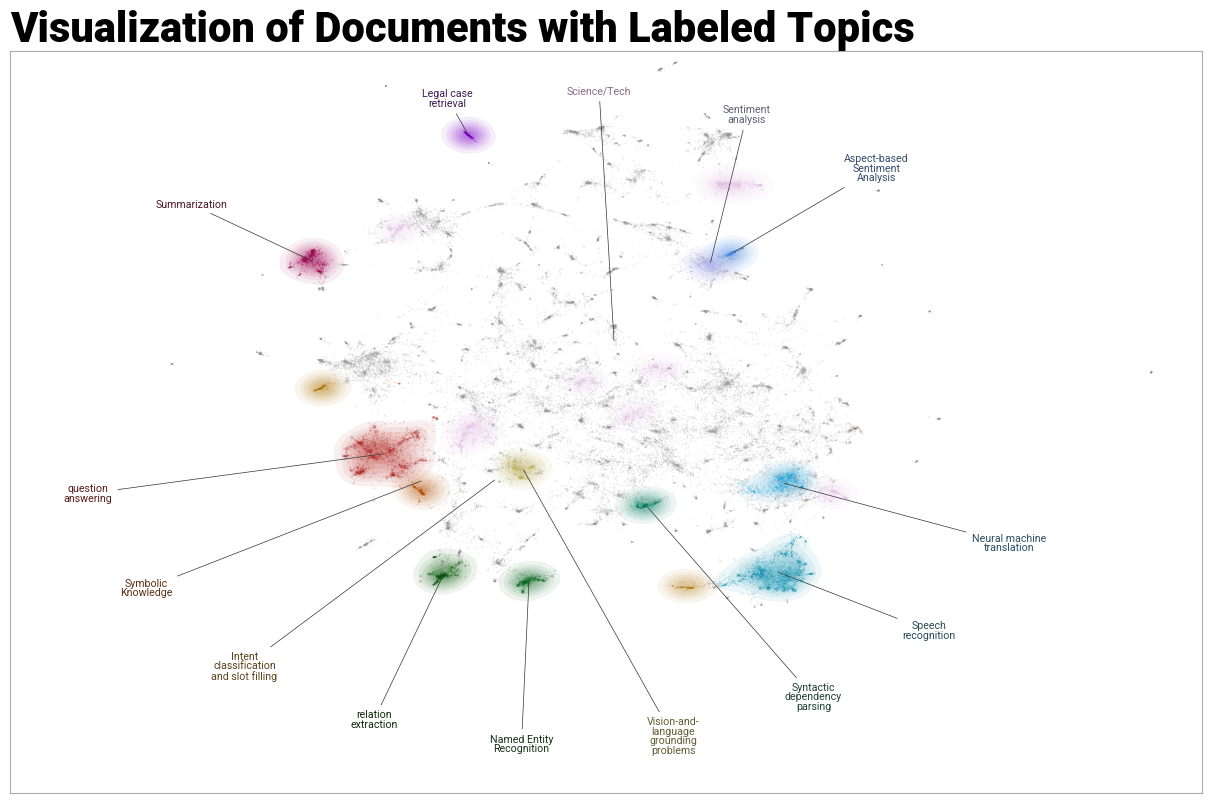

In [40]:
# Visualize documents with labeled topics
fig = topic_model.visualize_document_datamap(
    titles,
    title = "Visualization of Documents with Labeled Topics",
    topics=list(range(20)),
    reduced_embeddings=reduced_embeddings_2,
    width=1200
    #label_font_size=11,
    #label_wrap_width=20,
    #use_medoids=True,
)
plt.savefig("datamapplot.png", dpi=300)